In [48]:
#%matplotlib notebook
seed_val = 7
import os
os.environ['PYTHONHASHSEED'] = str(seed_val)
import random
random.seed(seed_val)
import numpy as np
np.random.seed(seed_val)
import pfsspy
import pfsspy.tracing as tracing
from sunpy.sun import constants as const
import astropy.units as u
from sunpy.net import Fido
from sunpy.net import attrs as a
from astropy.coordinates import SkyCoord
from sunpy.coordinates import Helioprojective
import matplotlib.pyplot as plt
# Using the sunpy Colormaps with matplotlib 
#import sunpy.visualization.colormaps as cm
import sunpy.map
from sunpy.coordinates import frames, get_body_heliographic_stonyhurst, get_horizons_coord
from matplotlib.patches import ConnectionPatch
import matplotlib
sdoaia193 = matplotlib.colormaps['sdoaia193']
import numpy as np
import astropy.io.fits as fits
# Show Plot in The Notebook 
#import matplotlib
#matplotlib.use('nbagg')
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

In [49]:
YEAR = '2019'
MONTH = '04'
DAY = '03'
start_hour = '12'
end_hour = '13'

In [52]:
maps = {m.detector: m.submap(SkyCoord([-1100, 1100], [-1100, 1100],
                                      unit=u.arcsec, frame=m.coordinate_frame))
        for m in sunpy.map.Map(['aia_map_20190403.fits', '20190403_120030_n4euA.fts'])}

# set the minimum plotted pixel value
#maps['AIA'].plot_settings['vmin'] = 0
#maps['EUVI'].plot_settings['vmin'] = 0 

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [72]:
# we use the AIA image and focus the cutout over the active region 
#aia_big = sunpy.map.Map('aia_map_20190403.fits')

aia_big = sunpy.map.Map(maps['AIA'])
euvi_big = sunpy.map.Map(maps['EUVI'])

left_corner = SkyCoord(Tx=-320*u.arcsec, Ty=100*u.arcsec, frame=aia_big.coordinate_frame)
right_corner = SkyCoord(Tx=50*u.arcsec, Ty=500*u.arcsec, frame=aia_big.coordinate_frame)

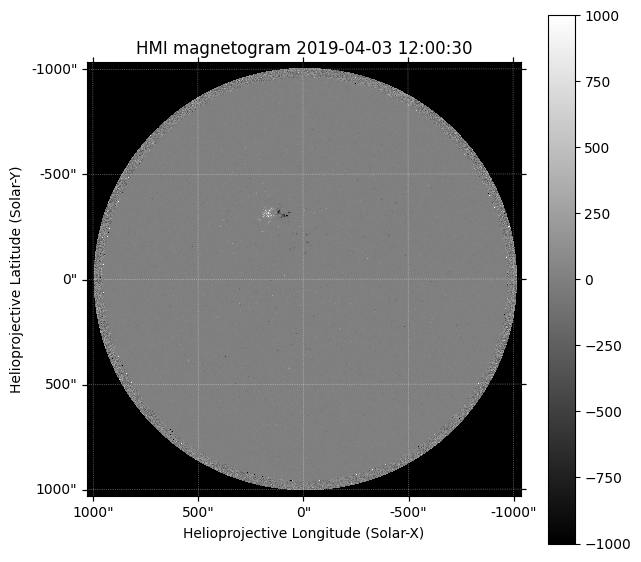

In [54]:
# obtain the HMI map
hmi = sunpy.map.Map('hmi.m_45s.2019.04.03_12_01_30_TAI.magnetogram.fits')

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=hmi)
hmi = hmi.rotate(180*u.deg)
norm = hmi.plot_settings['norm']
norm.vmin, norm.vmax = -1000, 1000
im = hmi.plot(axes=ax, norm=norm)
fig.colorbar(im)
plt.show()

In [55]:
sub_hmi = hmi.submap(left_corner, top_right=right_corner)

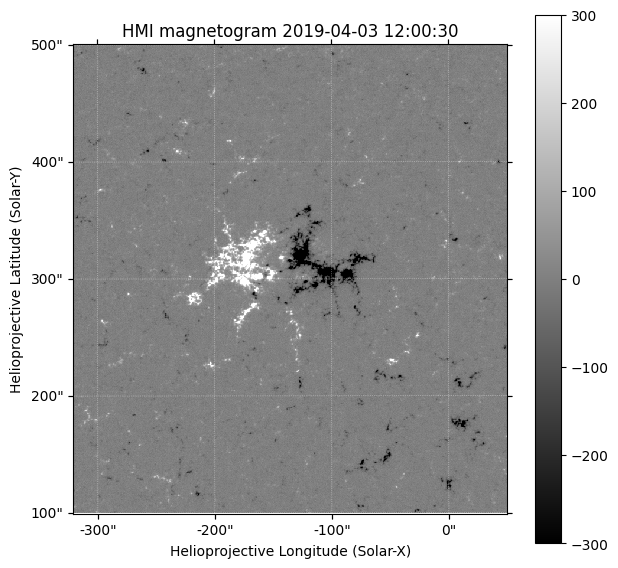

In [56]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=sub_hmi)
sub_norm = hmi.plot_settings['norm']
sub_norm.vmin, sub_norm.vmax = -300, 300
sub_im = sub_hmi.plot(axes=ax, norm=sub_norm)
fig.colorbar(sub_im)
plt.show()

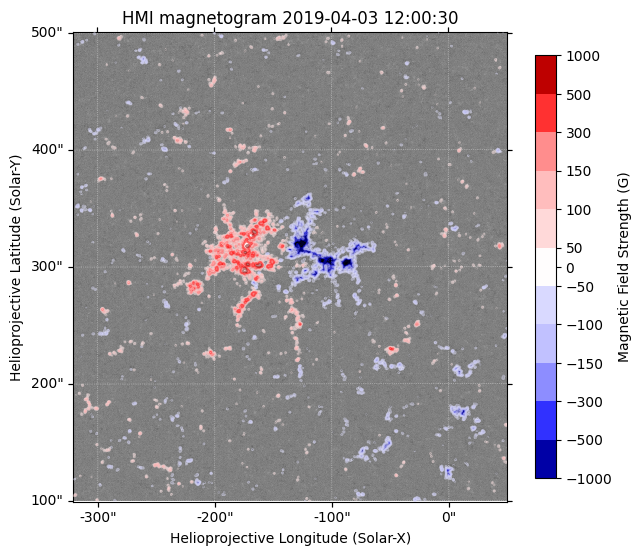

In [57]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection=sub_hmi)
sub_norm = hmi.plot_settings['norm']
sub_norm.vmin, sub_norm.vmax = -300, 300
sub_im = sub_hmi.plot(axes=ax, norm=sub_norm)

levels = [50, 100, 150, 300, 500, 1000]*u.Gauss
levels = np.concatenate((-1*levels[::-1], levels))
bounds = ax.axis()
cset = sub_hmi.draw_contours(levels, axes=ax, cmap='seismic', alpha=0.5)
ax.axis(bounds)

# Create a filled contour plot of the colorbar
colorbar = plt.contourf([[0,0], [0,0]], levels.value, cmap='seismic')
plt.colorbar(colorbar,
             label=f'Magnetic Field Strength ({sub_hmi.unit})',
             boundaries=levels.value,
             ticks=list(levels.value)+[0],
             shrink=0.8,
            # pad=0.17
            )
plt.show()

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


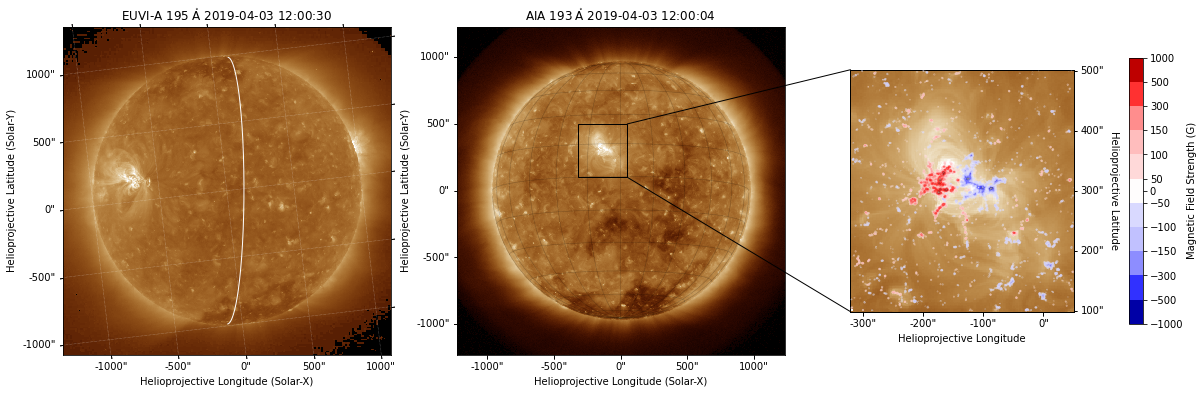

In [12]:
#### The first stage is plotting the full-disk AIA 193 Ao 
fig = plt.figure(figsize=(20,7))

ax1 = fig.add_subplot(131, projection=maps['EUVI'])
maps['EUVI'].plot(axes=ax1, clip_interval=(1, 99.99)*u.percent, cmap=sdoaia193)
visible, hidden = maps['AIA'].draw_limb(axes=ax1)
hidden.remove()

ax2 = fig.add_subplot(132, projection=aia_big)
aia_big.plot(axes=ax2, clip_interval=(1, 99.99)*u.percent, annotate=True)
aia_big.draw_grid(axes=ax2, color='black', alpha=0.25, lw=0.5)
ax2.grid(b=False)

# draw the rectangle around the region we plan to showcase in the cutout image 
aia_big.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)

#### The second stage is plotting the zoomed-in map 
aia_small = aia_big.submap(left_corner, top_right=right_corner)
ax3 = fig.add_subplot(133, projection=aia_small)

# make a nice normalization range for the imag 
norm = aia_big.plot_settings['norm']
norm.vmin, norm.vmax = np.percentile(aia_big.data, [1, 99.99])

im = aia_small.plot(axes=ax3, norm=norm, annotate=False)

# add HMI contours
levels = [50, 100, 150, 300, 500, 1000]*u.Gauss
levels = np.concatenate((-1*levels[::-1], levels))
bounds = ax3.axis()
cset = sub_hmi.draw_contours(levels, axes=ax3, cmap='seismic', alpha=0.5)
ax3.axis(bounds)

# Create a filled contour plot of the colorbar
colorbar = ax3.contourf([[0,0], [0,0]], levels.value, cmap='seismic')
plt.colorbar(colorbar,
             ax=ax3,
             label=f'Magnetic Field Strength ({sub_hmi.unit})',
             boundaries=levels.value,
             ticks=list(levels.value)+[0],
             shrink=0.7,
             pad=0.17
            )
ax3.grid(alpha=0)

# clean up the axis labels and ticks 
lon, lat = ax3.coords[0], ax3.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel('Helioprojective Longitude',)
lon.set_ticks_position('b')
lat.set_axislabel('Helioprojective Latitude',)
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# we add two lines that will connect the two images as well as a colorbar 
xpix, ypix = aia_big.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = aia_big.world_to_pixel(SkyCoord(right_corner.Tx, left_corner.Ty, frame=aia_big.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, arrowstyle='-', color='black', lw=1)

ax3.add_artist(con1)
ax3.add_artist(con2)
#plt.tight_layout()
#plt.savefig('/HDD/mnedal/plots/aia_sta_cutout.png', dpi=300, format='png', bbox_inches='tight')
#plt.savefig('/HDD/mnedal/plots/aia_sta_cutout.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [13]:
# GONG map and PFSS model
basedir = '/home/mnedal/ASTRON/'
gong_map = sunpy.map.Map(basedir+YEAR[-2:]+MONTH+DAY+'t'+start_hour+'04c2215_010.fits')

basedir_aia = '/home/mnedal/git/psp/'
aia = sunpy.map.Map(f'{basedir_aia}/aia_map_{YEAR}{MONTH}{DAY}.fits')

In [14]:
# The PFSS solution is calculated on a regular 3D grid in (phi, s, rho), where rho = ln(r), 
# and r is the standard spherical radial coordinate. 
# We need to define the number of grid points in rho, and the source surface radius. 
# From the boundary condition, number of radial grid points, and source surface, 
# we now construct an `Input` object that stores this information. 
# Using the `Input` object, plot the input photospheric magnetic field. 
nrho = 100
rss = 4
pfss_in = pfsspy.Input(gong_map, nrho, rss)
pfss_out = pfsspy.pfss(pfss_in)

# Now we construct a lat x lon grid of footpoitns to trace some magnetic field lines from. 
# These coordinates are defined in the helioprojective frame of the AIA image. 
num_footpoints = 60
lat = np.linspace(-0.49*np.pi, 0.49*np.pi, num_footpoints, endpoint=False)
lon = np.linspace(0*np.pi, 1*np.pi, num_footpoints, endpoint=False)

lat, lon = np.meshgrid(lat, lon, indexing='ij')
lat, lon = lat.ravel()*u.rad, lon.ravel()*u.rad
r = 1.2*const.radius

# Make a 2D grid from these 1D points 
seeds = SkyCoord(lon, lat, r, frame=pfss_out.coordinate_frame)
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


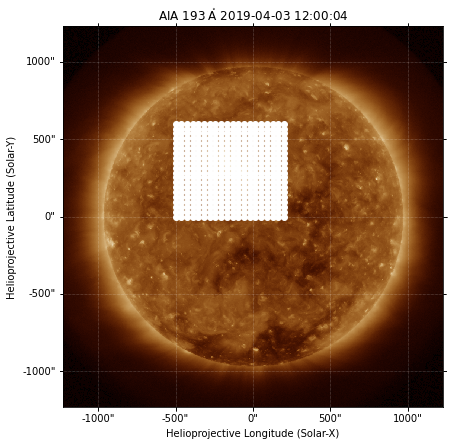

In [15]:
num_footpoints = 20
hp_lon = np.linspace(-500, 200, num_footpoints)*u.arcsec
hp_lat = np.linspace(0, 600, num_footpoints)*u.arcsec

# Make a 2D grid from these 1D points 
lon, lat = np.meshgrid(hp_lon, hp_lat)
r = 1.2*const.radius

fig = plt.figure(figsize=(7,7))
ax = plt.subplot(projection=aia)
aia.plot(axes=ax)

with Helioprojective.assume_spherical_screen(aia.observer_coordinate):
    seeds = SkyCoord(lon.ravel(), lat.ravel(), frame=aia.coordinate_frame)
    ax.plot_coord(seeds, color='white', marker='o', linewidth=0)

plt.show()

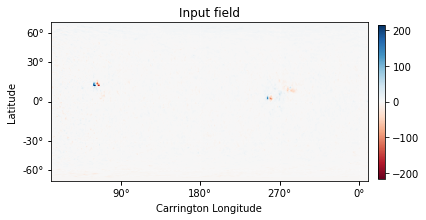

In [16]:
m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
img = m.plot()
fig.colorbar(img, fraction=0.023, pad=0.03)
ax.set_title('Input field')
plt.show()

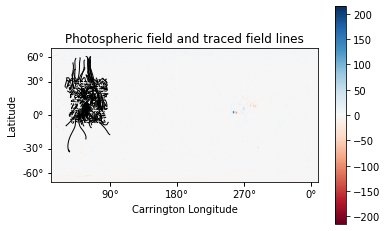

In [17]:
tracer = tracing.FortranTracer()
flines = tracer.trace(seeds, pfss_out)

m = pfss_in.map
fig = plt.figure()
ax = plt.subplot(projection=m)
m.plot()
for fline in flines:
    ax.plot_coord(fline.coords, color='black', linewidth=1)

ax.set_title('Photospheric field and traced field lines')
plt.colorbar()
plt.show()

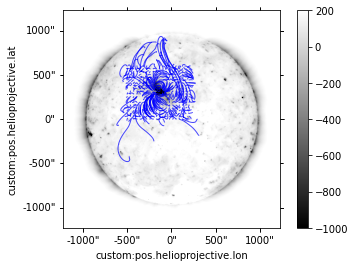

In [18]:
fig = plt.figure()
ax = plt.subplot(111, projection=aia)
im = ax.imshow(255-aia.data, vmin=-1000, vmax=200, cmap='gray')
for fline in flines:
    ax.plot_coord(fline.coords, alpha=0.7, linewidth=1, color='blue')

plt.colorbar(im)
plt.show()

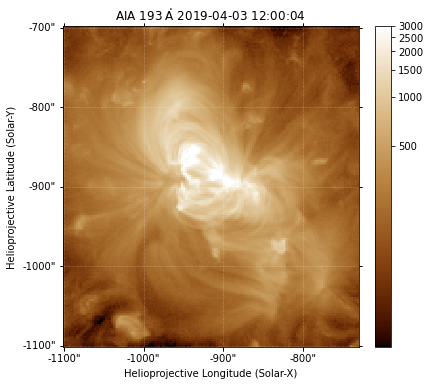

In [46]:
fig = plt.figure(figsize=[20,8])
ax = fig.add_subplot(131, projection=maps['AIA'])
aia_small = maps['AIA'].submap(left_corner, top_right=right_corner)
aia_small.plot(axes=ax,
               vmin=100,
               vmax=3e3
              )
plt.colorbar(fraction=0.049)
plt.show()

In [70]:
norm_aia = aia_big.plot_settings['norm']
norm_aia.vmin, norm_aia.vmax = np.percentile(aia_big.data, [1, 99.99])
norm_aia.vmin, norm_aia.vmax

(-0.1875, 2785.1153124996636)

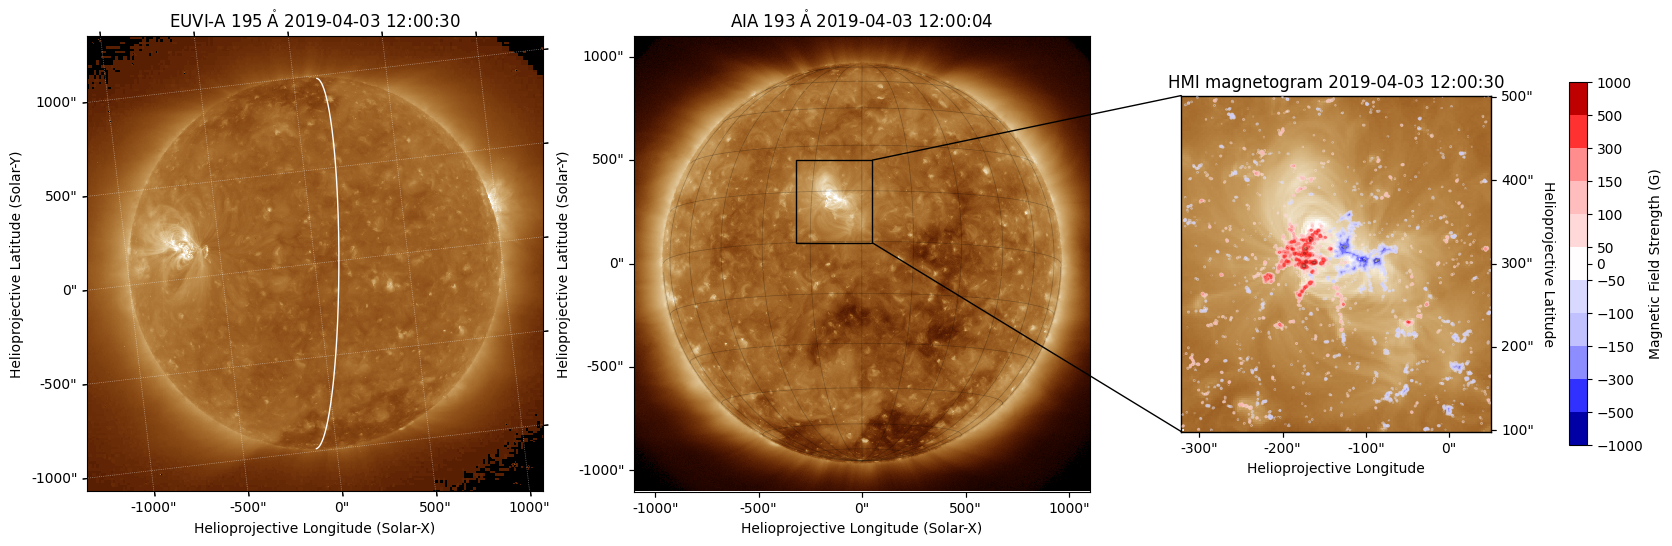

In [75]:
#### The first stage is plotting the full-disk AIA 193 Ao
fig = plt.figure(figsize=[20,8])

# make a nice normalization range for the img
norm_aia = aia_big.plot_settings['norm']
norm_aia.vmin, norm_aia.vmax = np.percentile(aia_big.data, [1, 99.99])

norm_euvi = euvi_big.plot_settings['norm']
norm_euvi.vmin, norm_euvi.vmax = np.percentile(euvi_big.data, [1, 99.99])

ax1 = fig.add_subplot(131, projection=euvi_big)
euvi_big.plot(axes=ax1,
              #clip_interval=(1, 99.99)*u.percent,
              cmap=sdoaia193)
visible, hidden = aia_big.draw_limb(axes=ax1)
hidden.remove()

ax2 = fig.add_subplot(132, projection=aia_big)
aia_big.plot(axes=ax2,
             #vmin=100, 
             #vmax=3e3, 
             annotate=True)
aia_big.draw_grid(axes=ax2, color='black', alpha=0.25, lw=0.5)
ax2.grid(b=False)

# draw the rectangle around the region we plan to showcase in the cutout image
aia_big.draw_quadrangle(left_corner, top_right=right_corner, edgecolor='black', lw=1)

#### The second stage is plotting the zoomed-in map
aia_small = aia_big.submap(left_corner, top_right=right_corner)
ax3 = fig.add_subplot(133, projection=aia_small)

im = aia_small.plot(axes=ax3, 
                    norm=norm_aia,
                    #vmin=100, 
                    #vmax=3e3, 
                    annotate=False)

# add HMI contours
levels = [50, 100, 150, 300, 500, 1000]*u.Gauss
levels = np.concatenate((-1*levels[::-1], levels))
bounds = ax3.axis()
cset = sub_hmi.draw_contours(levels, axes=ax3, cmap='seismic', alpha=0.5)
ax3.axis(bounds)

# Create a filled contour plot of the colorbar
colorbar = ax3.contourf([[0,0], [0,0]], levels.value, cmap='seismic')
plt.colorbar(colorbar,
             ax=ax3,
             label=f'Magnetic Field Strength ({sub_hmi.unit})',
             boundaries=levels.value,
             ticks=list(levels.value)+[0],
             shrink=0.6,
             pad=0.17
            )
ax3.set_title(hmi.name)
ax3.grid(alpha=0)

# Add PFSS lines
'''
for fline in flines:
    ax3.plot_coord(fline.coords, alpha=0.5, linewidth=1, color='black')
'''
# clean up the axis labels and ticks
lon, lat = ax3.coords[0], ax3.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel('Helioprojective Longitude',)
lon.set_ticks_position('b')
lat.set_axislabel('Helioprojective Latitude',)
lat.set_axislabel_position('r')
lat.set_ticks_position('r')
lat.set_ticklabel_position('r')

# we add two lines that will connect the two images as well as a colorbar
xpix, ypix = aia_big.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0,1), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, 
    arrowstyle='-', color='black', lw=1)

xpix, ypix = aia_big.world_to_pixel(SkyCoord(right_corner.Tx, left_corner.Ty, frame=aia_big.coordinate_frame))
con2 = ConnectionPatch(
    (0,0), (xpix.value, ypix.value), 'axes fraction', 'data', axesA=ax3, axesB=ax2, arrowstyle='-', color='black', lw=1)

ax3.add_artist(con1)
ax3.add_artist(con2)
fig.savefig('/HDD/mnedal/plots/aia_sta_cutout.png', dpi=300, format='png', bbox_inches='tight')
fig.savefig('/HDD/mnedal/plots/aia_sta_cutout.pdf', format='pdf', bbox_inches='tight')
plt.show()

### Get the AR 12738 location from EUVI

In [ ]:
from sunpy.net import Fido, attrs as a
from sunpy.net.dataretriever import QueryResponse

# Specify the NOAA Active Region Number (AR number)
noaa_number = '12738'

# Query for information about the active region
results = Fido.search(a.Instrument('NOAA-AR'), a.AR, a.Metadata(noaa_number))

# Filter the results to include only FITS files
filtered_results = [file for file in results if file['filetype'] == 'fits']

# Download the filtered results
downloaded_files = Fido.fetch(filtered_results)

# Print the query results
print(downloaded_files)

# Access specific information from the query response
if isinstance(downloaded_files, QueryResponse):
    for r in downloaded_files:
        print('Start Time:', r.time.start)
        print('End Time:', r.time.end)
        print('Instrument:', r.instrument)
        # Add more attributes as needed

In [ ]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import sunpy.map
from sunpy.net import Fido, attrs as a

# Define the observation time
observation_time = '2019-04-03T12:15:00'

# Search for the EUVI data for the specified time
result = Fido.search(a.Instrument('EUVI'),
                     a.Time(observation_time),
                     a.vso.Physobs('intensity'))

# Download the EUVI data
downloaded_files = Fido.fetch(result)

# Load the EUVI map
euvi_map = sunpy.map.Map(downloaded_files)

# Find the active region by its NOAA number
noaa_number = 12738
active_region_mask = euvi_map.meta['NOAA_AR'] == noaa_number

# Get the coordinates of the active region
active_region_coords = euvi_map.pixel_to_world(0, 0)
active_region_coords = SkyCoord(active_region_coords.Tx, active_region_coords.Ty, frame=euvi_map.coordinate_frame)

# Print the coordinates of the active region
print('Active region AR {} location at {}:'.format(noaa_number, observation_time))
print('Heliographic Longitude: {}'.format(active_region_coords.lon))
print('Heliographic Latitude: {}'.format(active_region_coords.lat))